In [ ]:
!pip install pyro-ppl torch gpytorch

     |████████████████████████████████| 678 kB 4.2 MB/s 
     |████████████████████████████████| 503 kB 26.2 MB/s 


In [ ]:
import torch
import gpytorch
import numpy as np
from gpytorch.priors import GammaPrior, UniformPrior

import pyro
from pyro.infer.mcmc import NUTS, HMC, MCMC

import matplotlib.pyplot as plt


%matplotlib inline
torch.set_default_tensor_type(torch.DoubleTensor)

In [ ]:
def noisy_sin_function(x):
  """
  takes numpy array (x) as argument and computes sin of array.
  """
  # reproducibility: 
  # np.random.seed(1)
  return np.sin(x[:, 0]) * np.sin(x[:, 1]) + np.random.randn(x.shape[0]) * 0.01

def plot_function(input_xy):
  """
  Plots a sin function colormap for a 2d input with color representing value.
  """
  n = 100
  x = np.linspace(0, 4, n)
  y = np.linspace(0, 4, n)

  xx, yy = np.meshgrid(x, y)
  pts = np.vstack([xx.ravel(), yy.ravel()]).T

  # print(pts.shape)
  
  z = noisy_sin_function(pts)

  fig, ax = plt.subplots(figsize=(8,8))
  surf = ax.pcolor(xx, yy, z.reshape(n, n))
  plt.plot(input_xy[:,0], input_xy[:,1], 'o', color='k')
  plt.rc('font', size=16)  
  plt.xlabel("X1")
  plt.ylabel("X2")
  cbar = fig.colorbar(surf)
  cbar.set_label("f(x1 , x2)")
  plt.show()

def rect_points(start, end, n, ax):
  """

  returns an array of points in a rectangle.

  start = x axis where rectangle starts
  end = x axis where rectangle ends
  n = number of addition points
  ax = x axis where addition points are added
  """

  # holds points in square:
  points = []

  # base points to make square of 4 points:
  p1 = np.linspace(start,end, num=2)
  p2 = p1[::-1]
  points.append(p1)
  points.append(p2)
  points.append(np.array([start, start]))
  points.append(np.array([end, end]))

  # additional points:
  if ax==start or ax==end:
    n += 2
  p3 = np.linspace(start, end, num=n)

  points = np.array(points)

  for i in p3:
    l = np.array([ax, i])
    # print(l)
    # print((l == points).all(1).any())
    if not (l == points).all(1).any():
      points = np.append([l], points, axis=0)

  return points



# Input Space

(8, 2)
(1, 8)


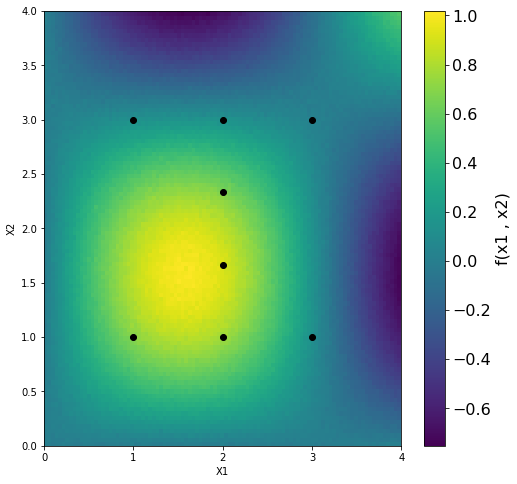

In [ ]:
num_data = 5
input_xy = rect_points(start=1,end=3,n=4, ax=2)
print(input_xy.shape)

z = noisy_sin_function(input_xy)
z = z.reshape(1,-1)

print(z.shape)

plot_function(input_xy)

# Algorithm Start
### obtain prior



In [ ]:
input_xy = torch.Tensor(input_xy)

train_x = input_xy
train_y = torch.Tensor(z)

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())

model = ExactGPModel(train_x, train_y, likelihood)

model.covar_module.base_kernel.register_prior("lengthscale_prior", GammaPrior(1,1), "lengthscale")
model.covar_module.register_prior("outputscale_prior", GammaPrior(1,1), "outputscale")
likelihood.register_prior("noise_prior", GammaPrior(1,1), "noise") # ??

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

### MCMC Sampling

In [ ]:
num_hyper_samples = 10000
warmup_steps = 2000 

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=num_hyper_samples, warmup_steps=warmup_steps)
mcmc_run.run(train_x, train_y)

# sometimes cholesky fails

Warmup:  16%|█▌        | 1949/12000 [03:10, 10.78it/s, step size=3.28e-01, acc. prob=0.791]/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
Sample: 100%|██████████| 12000/12000 [24:18,  8.23it/s, step size=2.98e-01, acc. prob=0.940]


### MCMC Samples

In [ ]:
hyperparam = list(mcmc_run.get_samples().keys())

kl_samples = mcmc_run.get_samples()[hyperparam[0]]
kv_samples = mcmc_run.get_samples()[hyperparam[1]]
nv_samples = mcmc_run.get_samples()[hyperparam[2]]

parameter_samples = [kl_samples, kv_samples, nv_samples]

In [ ]:
def get_mixture_stds(means, stds):
    """
    Return standard deviation of a k-component Gaussian mixture model, given an
    (k x n) array of k component means for n locations, and a (k x n) array of
    k component stds for n locations.
    """
    mixture_means = np.mean(means, axis=0)
    sums_squared_means_stds = means ** 2 + stds ** 2
    second_moments = np.mean(sums_squared_means_stds, axis=0)
    mixture_vars = second_moments - mixture_means ** 2
    mixture_stds = np.sqrt(mixture_vars)
    return mixture_stds

### Acquisition function loop to obtain equation term values

In [ ]:
NUM_POST_PRED = 100
sampled_hyper_indx = []

# np.random.seed(2) # ensures we are working with same indices  

# DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS OF SIZE NUM_POST_PRED:
for i in range(NUM_POST_PRED):
  sampled_hyper_indx.append(np.random.randint(0,num_hyper_samples))

# TESTING POINTS (INPUT):
n = 100
x = np.linspace(0, 4, n)
y = np.linspace(0, 4, n)

xx, yy = np.meshgrid(x, y)
test_points = torch.Tensor( np.vstack([xx.ravel(), yy.ravel()]).T )

num_test = test_points.shape[0]
print(test_points.shape)


# DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS:
# print(f"sampled_hyper_indx: {sampled_hyper_indx}")

means = []
stds = []
entropies = []

for indx in sampled_hyper_indx:
  # CREATE GPR MODEL:
  likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive()) 
  m = ExactGPModel(train_x, train_y, likelihood)   

  hypers = {
      hyperparam[0][:-6]: parameter_samples[0][indx].numpy()[0][0], #l
      hyperparam[1][:-6]: parameter_samples[1][indx].numpy(),       #v
      hyperparam[2][:-6]: parameter_samples[2][indx].numpy()[0] } #n

  # assign hyperparams from sampled hyperparam distributions:
  m.initialize(**hypers)

  # print(f"lengthscale: {parameter_samples[0][indx].numpy()[0][0]}")
  # print(f"kernel variance: {parameter_samples[1][indx].numpy()}")
  # print(f"noise variance: {parameter_samples[2][indx].numpy()[0]} \n")

  # OBTAIN MEAN AND VARIANCE OF F AT A POINTS "test_points"
  m.eval()                                                      
  with torch.no_grad():
    predictions = m(test_points)  
    mean = predictions.mean.detach().numpy()
    var = predictions.variance.detach().numpy()

  # print(mean.shape)
  # print(var.shape)

  mean = np.squeeze(mean)
  std = np.sqrt( np.squeeze(var) )

  means += [mean]
  stds += [std]

  # CREATE GAUSSIAN DISTRIBUTIONS WITH MEAN AND VARIANCES AND FIND ENTROPY:
  e = [] # holds entropies for "num_test" distributions
  import torch.distributions as tdist
  for i in range(num_test):
    distribution_2 = tdist.Normal(mean[i], var[i])
    #distribution_2 = torch.normal( mean=mean[i], std=var[i] )
    e.append(distribution_2.entropy().detach().numpy())
    # print(f'mean {mean[i]}, var {var[i]}, entropy {distribution_2.entropy().numpy()}')

  entropies.append(e)

torch.Size([10000, 2])
lengthscale: 2.364878043122758
kernel variance: 0.26524538116429497
noise variance: 0.10382301745088862 

lengthscale: 3.0416644409111324
kernel variance: 0.09715350504928166
noise variance: 0.16292799072249325 

lengthscale: 5.164105465906781
kernel variance: 1.2263108661466064
noise variance: 0.20552848319969105 

lengthscale: 1.3114291496410189
kernel variance: 0.2059320677647749
noise variance: 0.15575295913383377 

lengthscale: 1.4190693773367036
kernel variance: 0.3379918713819778
noise variance: 0.045030271698875746 

lengthscale: 1.270127010134956
kernel variance: 0.38615518780452585
noise variance: 0.0013010077759279496 

lengthscale: 1.4144723648419053
kernel variance: 0.1369981921427753
noise variance: 0.12808708870248978 

lengthscale: 1.1468152480436906
kernel variance: 0.36160850209347434
noise variance: 0.001892492307878763 

lengthscale: 1.0750598509496656
kernel variance: 0.44879381025355963
noise variance: 0.04293676065394294 

lengthscale: 1.42

### Final Results

In [ ]:
means = np.array(means)
stds = np.array(stds)
entropies = np.array(entropies)

# COMPUTATIONS TO OBTAIN 1ST TERM IN EQUATION:
print(f"average mean: {np.mean(means, axis=0)}")
print(f"std deviation of means: {np.std(means, axis=0)}")
mixture_means = np.mean(means, axis=0)
mixture_stds = get_mixture_stds(means, stds)

distribution_1 = tdist.Normal(torch.tensor(np.array(mixture_means)), torch.tensor(np.array(mixture_stds)))

entropy_of_avg = distribution_1.entropy().detach().numpy().reshape(-1,1)

# COMPUTATIONS TO OBTAIN 2ND TERM IN EQUATION:
avg_entropy = np.mean(entropies, axis=0).reshape(-1,1)
print(avg_entropy.shape)

# stick in variable:
print(f"ENTROPY OF AVG (1st term): {entropy_of_avg}")
print(f"AVG OF ENTROPY (2nd term): {avg_entropy}")

acq_value = entropy_of_avg - avg_entropy
print(f"ACQUISITION FUNCTION VALUE: {acq_value}")

average mean: [ 0.17393384  0.18033131  0.18682518 ... -0.08403642 -0.08252266
 -0.08101801]
std deviation of means: [0.15164402 0.15177497 0.15187564 ... 0.09938111 0.09848723 0.09762198]
(10000, 1)
ENTROPY OF AVG (1st term): [[0.77907064]
 [0.77187012]
 [0.76461003]
 ...
 [0.73958543]
 [0.7469349 ]
 [0.75425539]]
AVG OF ENTROPY (2nd term): [[-0.19417778]
 [-0.21019252]
 [-0.22640967]
 ...
 [-0.22640967]
 [-0.21019252]
 [-0.19417778]]
ACQUISITION FUNCTION VALUE: [[0.97324842]
 [0.98206264]
 [0.9910197 ]
 ...
 [0.96599511]
 [0.95712742]
 [0.94843317]]


In [ ]:
acq_opt_idx = np.argmax(acq_value)
print(f'acq_opt_idx = {acq_opt_idx}')
mat_idx_1 = int(acq_opt_idx / 100)
mat_idx_2 = acq_opt_idx - (mat_idx_1 * 100)
print(mat_idx_1)
print(mat_idx_2)
print(xx[mat_idx_1, mat_idx_2])
print(yy[mat_idx_1, mat_idx_2])

acq_opt_idx = 3449
34
49
1.97979797979798
1.373737373737374


torch.Size([8, 2])


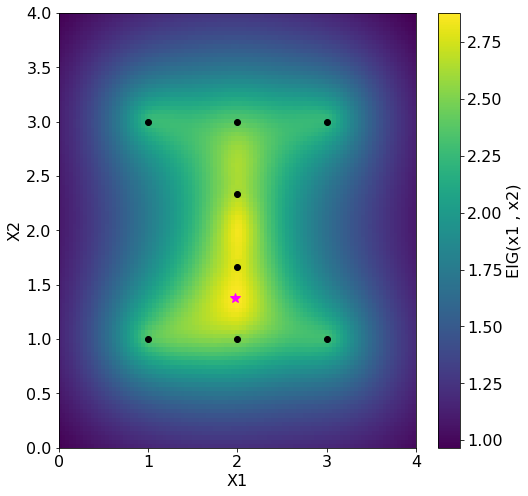

In [ ]:
print(input_xy.shape)
plt.figure(figsize=(8, 8))
plt.rc('font', size=16)  
plt.xlabel("X1")
plt.ylabel("X2")
plt.pcolor(xx,yy,acq_value.reshape(n,n))
plt.plot(input_xy[:,0], input_xy[:,1], 'o', color='k')
plt.plot(xx[mat_idx_1, mat_idx_2], yy[mat_idx_1, mat_idx_2], '*', c="magenta", markersize=10)
cbar = plt.colorbar()
cbar.set_label("EIG(x1 , x2)")

Text(0, 0.5, 'hyperparameter values')

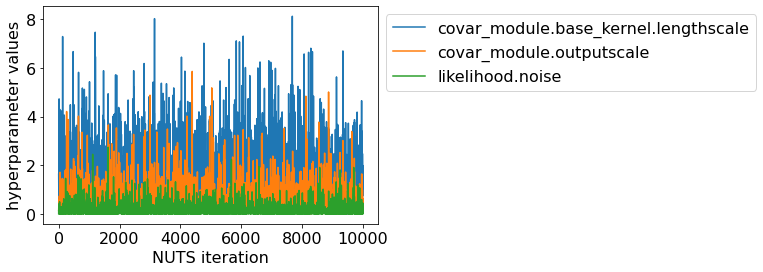

In [ ]:
plt.figure(figsize=(8, 4))

for i,val in enumerate(parameter_samples):
  plt.plot(np.squeeze(val), label=hyperparam[i][:-6])

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("NUTS iteration")
plt.ylabel("hyperparameter values") # update NUTS or HMC

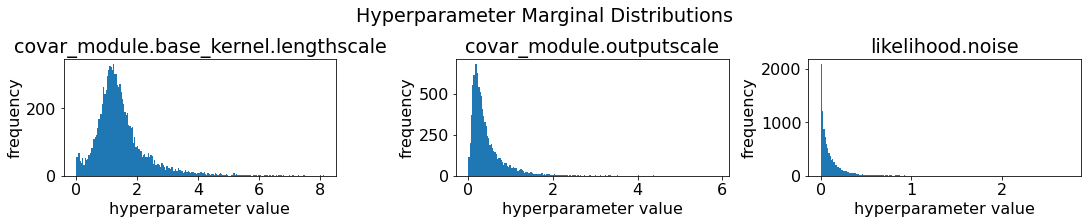

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)

for i, (ax, val) in enumerate(zip(axes,parameter_samples)):
  ax.hist(np.stack(val).flatten(), bins=200)
  ax.set_title(hyperparam[i][:-6])
  ax.set_ylabel('frequency')
  ax.set_xlabel('hyperparameter value')
  
fig.suptitle("Hyperparameter Marginal Distributions");
